# Comparing Boosting Algorithms (and Bagging) using the CharityML dataset
#### by Palermo Penano

I've read a lot of articles about XGBoost and how it just blows away all other boosting (and non-boosting) algorithms. My goal in this notebook is to see this for myself. This notebook compares the performance of three boosting algorithms using the [CharityML](https://archive.ics.uci.edu/ml/datasets/Census+Income) dataset. These three algorithms are AdaBoost, Scikit-Learn's implementation of gradient boosting (GBC), and its improved version, XGBoost. I also compare bagging with the boosting algorithm.

The boosting technique is an approach used in ensemble learning which trains a series of learning models---called weak learners---that improve with each iteration. The weak learners are trained in sequence with each weak learner accounting for the mistakes of the previous weak learner and as a result improving its own predictive performance. The final predictions are then made based on the aggregate predictions of each individual weak learner.

The key difference between AdaBoost and gradient boosting is in the way each weak learner improve on its predecessor. For AdaBoost, the points that are misclassified by the current weak learner are assigned greater weight in the next iteration. This changes the distribution of points resulting in greater emphasis on the avoidance of misclassifying these points again when training the next weak learner. 

Gradient boosting takes a slightly different approach. Instead of changing the weights of the misclassified points of the previous weak learner, the current weak learner adjusts the prediction itself. This adjustment are based on the error residuals calculated from estimates made by the predecessor weak learner. It turns out that this method of learning is very similar to the way the gradient descent algorithm work, hence the name. This is more clearly explained in the [informal introduction](https://en.wikipedia.org/wiki/Gradient_boosting) on gradient boosting on Wikipedia. The advantage of gradient boosting over AdaBoost is it lets you use any differentiable loss function. With AdaBoost, you're limited to using just exponential loss.

XGBoost is everything that the vanilla gradient boosting algorithm wanted to be growing up. It's the friend that got into all the good schools, received offers at all the cool jobs, and dated all the good-looking and smart people. In the domain of machine learning competition, it is the algorithm behind many winning solutions in competitions using structured data.

XGBoost is just a gradient boosting algorithm with improved features. This [article](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) clearly outlines its advantages. One particularly important feature of XGBoost is its capacity to scale. Boosting algorithms are sequentially trained making it difficult to parallelize the construction of each tree. XGBoost, however, parallelizes the construction of nodes and splits within each tree resulting in faster training time [[1](http://zhanpengfang.github.io/418home.html)][[2](https://machinelearningmastery.com/best-tune-multithreading-support-xgboost-python/)].

#### __Summary of Results__

The comparison across the algorithms is made for different values of the sample size and number of weak learners used.

The main results can be found under the __Plot data__ section. In accuracy performance on the test set, both GBC and XGBoost similarly performed better than both AdaBoost and the bagging classifer as sample size increased with bagging doing the worst. Using the F-test with $\beta = 0.5$ to emphasize precision, XGBoost performed marginally better than GBC. AdaBoost is a a few percentage points below GBC with bagging performing much worse (F-score of around 0.68  v.s. 0.74 for the XGBoost).

The most important thing to note is that, although GBC performed almost just as well as XGBoost in the test set, training time using the GBC algorithm is much longer. In the full sample, GBC took 8 seconds to train wherease XGBoost took only a little over 3 seconds. AdaBoost was the quickest at around 1.5 seconds using the full sample, though it does not perform as well as GBC and XGBoost.

As we increase the number of weak learners, all boosting algorithms improves both in the accuracy and F-score in the test set. Bagging continues to perform poorly relative to boosting with no noticeable increase in perfomance with more trees trained. GBC performs slightly better than XGBoost, but its training time increases at much faster rate than XGBoost as the number of weak learners increases.

As a summary, using the CharityML dataset, we find that GBC and XGBoost perform similarly well but XGBoost is able to scale better and handle greater complexity as the sample size and the number of weak learners increases.


### References
1. [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
2. [Good video explaining gradient boosting](https://www.youtube.com/watch?v=sRktKszFmSk)
3. [Tutorial on XGBoost][2]

### Installing XGBoost

The original instructions to install XGBoost can be found [here][1]. I had trouble installing it following these instructions which I suspect is because I'm using the Anaconda distribution. I was able to install it using this command

```
conda install -c conda-forge xgboost=0.6a2
``` 

which I found on Stack Overflow [here][3]. 

[1]: http://xgboost.readthedocs.io/en/latest/build.html
[2]: http://xgboost.readthedocs.io/en/latest/model.html
[3]: https://stackoverflow.com/questions/43464454/install-xgboost-on-anaconda

In [1]:
import sys
sys.version

'3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [109]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline
import pprint as pp

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=2))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


## Prepare Data

The dataset I use is CharityML which contain the following features

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

The outcome variable is income, which is a categorical variable indicating whether the indivdual earns more than \$50,000

Engineer continuous features by taking their log transformation and scaling them using min max scaler. One-hot encode categorical variables and convert ground truth variable to dummy values

In [3]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw)
income = income['>50K']

## Shuffle and Split Data
Create training and testing set

In [4]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/Users/palermospenano/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Training and Prediction Pipeline

This function trains the learner and collects data on training time and prediction score on the training and testing set. The score are based on accuracy and the F-score with $\beta = 0.5$ to place greater weight on precision. Using the F-score as a metric is important because the data is unbalanced. More weight on precision follows from the nature of the predicition problem: we are looking to predict individuals who earned greater than $\$50,000$ and are therefore more likely to make a charitable donation. We want to be sure that we avoid mistakenly classifying those who make under $\$50,000$ and wasting resources trying to solicit charitable donations from them. Precision measures the share of people who really do make $>\$50,000$ among those our algorithm have classified as making $>\$50,000$.

In [5]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 
    # 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test), then get 
    # predictions on the first 500 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:500])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on training (the first 500 training samples) and test set
    results['acc_train'] = accuracy_score(y_train[:500], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the training (first 500) and test set
    results['f_train'] = fbeta_score(y_train[:500], predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)

    return results

## Training

We train and collect performance and run time data on the AdaBoost, Gradient boosting, XGBoost, and the Bagging classifiers as we vary the sample size and the number of weak learners. All four meta-classifiers use decision trees as their base estimators.

In [129]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

clf_A = AdaBoostClassifier()
clf_B = GradientBoostingClassifier()
clf_C = XGBClassifier()
clf_D = BaggingClassifier()

samples_100 = len(y_train)
samples_80 = int(samples_100 * .80)
samples_50 = int(samples_100 * .50)
samples_25 = int(samples_100 * .25)
samples_10 = int(samples_100 * .10)
samples_1 = int(samples_100 * .01)

models = [clf_A, clf_B, clf_C, clf_D]
# models = [clf_D]
sample_sizes = [samples_1, 
                samples_10, 
                samples_25,
                samples_50,
                samples_80,
                samples_100]

num_trees = [10, 30, 50, 70, 100, 150, 200, 250, 300, 350]

results_samples = {}
results_num_trees = {}

# performance across sample sizes
for clf in models:

    clf_name = clf.__class__.__name__
    
    print('Performance across sample size') 
    results_samples[clf_name] = {}
    for i, sample in enumerate(sample_sizes):
        
        print("{} trained on {} samples".format(clf_name, sample))
        results_samples[clf_name]['size_{}'.format(sample)] = \
        train_predict(clf, sample, X_train, y_train, X_test, y_test)
    
    print("")
    
    print("Performance based on number of trees on 100% sample")
    results_num_trees[clf_name] = {}
    for i, num_tree in enumerate(num_trees):
        
        print("{} trains with {} number of trees".format(clf_name, num_tree))
        clf = clf.set_params(n_estimators=num_tree)
        results_num_trees[clf_name]['num_tree_{}'.format(num_tree)] = \
        train_predict(clf, samples_100, X_train, y_train, X_test, y_test)
    
    print("")
        

Performance across sample size
AdaBoostClassifier trained on 361 samples
AdaBoostClassifier trained on 3617 samples
AdaBoostClassifier trained on 9044 samples
AdaBoostClassifier trained on 18088 samples
AdaBoostClassifier trained on 28941 samples
AdaBoostClassifier trained on 36177 samples

Performance based on number of trees on 100% sample
AdaBoostClassifier trains with 10 number of trees
AdaBoostClassifier trains with 30 number of trees
AdaBoostClassifier trains with 50 number of trees
AdaBoostClassifier trains with 70 number of trees
AdaBoostClassifier trains with 100 number of trees
AdaBoostClassifier trains with 150 number of trees
AdaBoostClassifier trains with 200 number of trees
AdaBoostClassifier trains with 250 number of trees
AdaBoostClassifier trains with 300 number of trees
AdaBoostClassifier trains with 350 number of trees

Performance across sample size
GradientBoostingClassifier trained on 361 samples
GradientBoostingClassifier trained on 3617 samples
GradientBoostingC

## Organize data collected during training

In [142]:
def get_tree_data(learner, statistic):
    
    data = []
    
    for t in num_trees:
        data.append(results_num_trees[learner]['num_tree_{}'.format(t)][statistic])
        
    return data

def get_sample_data(learner, statistic):

    data = []
    
    for s in sample_sizes:
        data.append(results_samples[learner]['size_{}'.format(s)][statistic])
        
    return data

def data_to_df(learner, func_type, hyperparam_list):

    df = pd.DataFrame({'f_train': func_type(learner, 'f_train'),
                        'f_test': func_type(learner, 'f_test'),
                        'acc_test': func_type(learner, 'acc_test'),
                        'pred_time': func_type(learner, 'pred_time'),
                        'train_time': func_type(learner, 'train_time'),
                        'hyperparam_list': hyperparam_list})
    df = df.set_index('hyperparam_list')
    return df

In [143]:
ada_sample = data_to_df('AdaBoostClassifier', get_sample_data, sample_sizes)
gbc_sample = data_to_df('GradientBoostingClassifier', get_sample_data, sample_sizes)
xgb_sample = data_to_df('XGBClassifier', get_sample_data, sample_sizes)
bag_sample = data_to_df('BaggingClassifier', get_sample_data, sample_sizes)

ada_tree = data_to_df('AdaBoostClassifier', get_tree_data, num_trees)
gbc_tree = data_to_df('GradientBoostingClassifier', get_tree_data, num_trees)
xgb_tree = data_to_df('XGBClassifier', get_tree_data, num_trees)
bag_tree = data_to_df('BaggingClassifier', get_tree_data, num_trees)

In [157]:
xgb_tree

,acc_test,f_test,f_train,pred_time,train_time
hyperparam_list,,,,,
10,0.844334,0.698834,0.694118,0.049934,0.504201
30,0.851410,0.716307,0.724466,0.052461,1.035866
50,0.854726,0.724214,0.731415,0.054653,1.900655
70,0.858596,0.734794,0.743405,0.059459,2.396405
100,0.863239,0.743543,0.748219,0.057615,4.100895
150,0.864677,0.742895,0.759637,0.066224,5.646442
200,0.867219,0.747220,0.782313,0.061736,6.382848
250,0.868104,0.748420,0.779510,0.078409,8.466889
300,0.868878,0.750027,0.775281,0.070364,9.094014


## Plot data

### Changing the sample size

Plotting acc_test


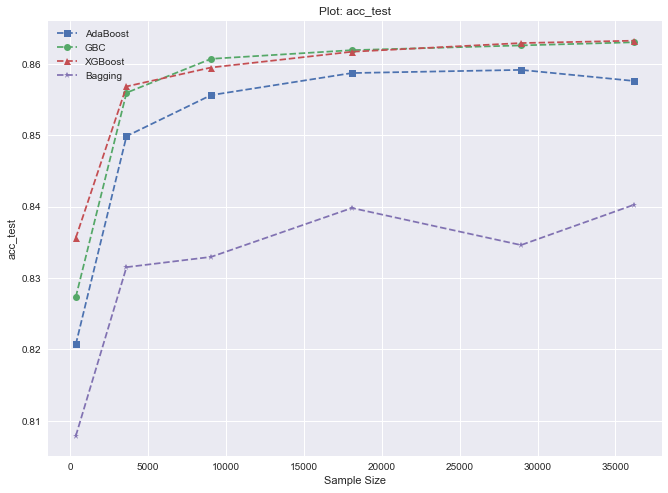

Plotting f_test


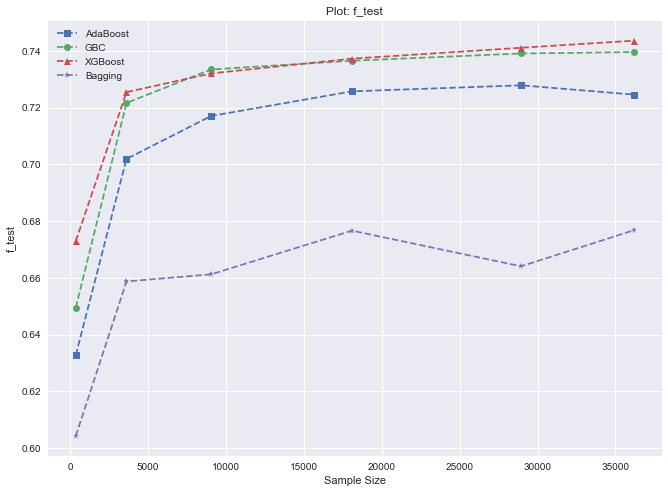

Plotting train_time


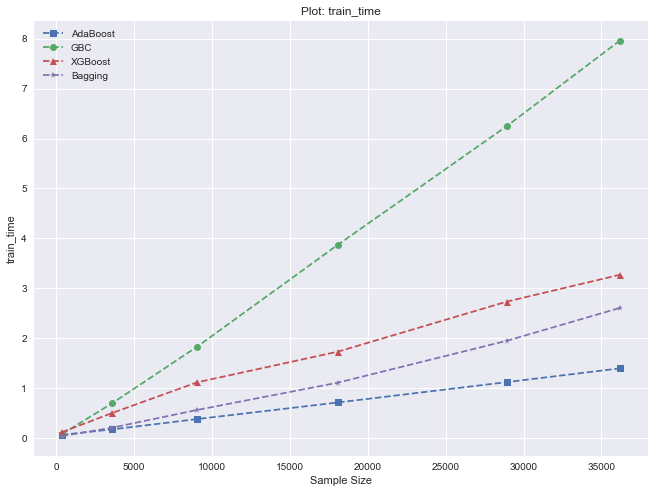

In [144]:
cols = ['acc_test', 'f_test', 'train_time']

for col in cols:

    print("Plotting {}".format(col))
    
    plt.figure(figsize=(11, 8))
    
    plt.plot(ada_sample[col], '--s',label='AdaBoost')
    plt.plot(gbc_sample[col],'--o',label='GBC')
    plt.plot(xgb_sample[col], '--^', label='XGBoost')
    plt.plot(bag_sample[col], '--*', label='Bagging')
    
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('{}'.format(col))
    plt.title('Plot: {}'.format(col))
    plt.show()

### Changing the number of weak learners

Plotting acc_test


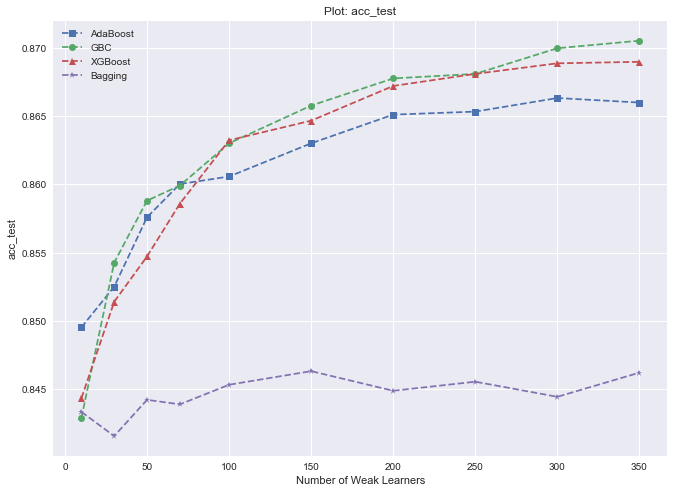

Plotting f_test


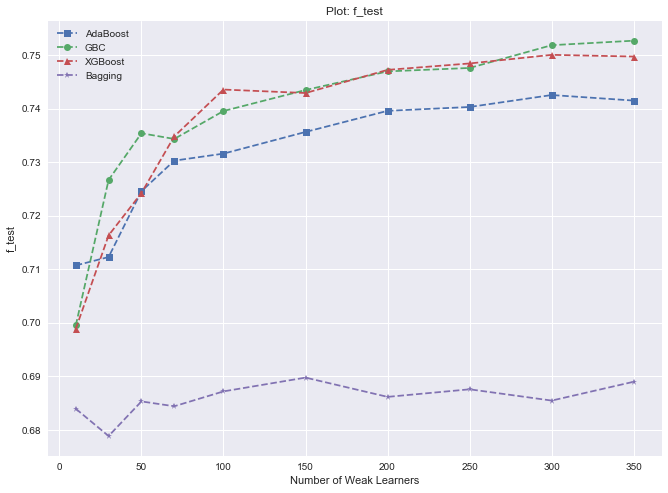

Plotting train_time


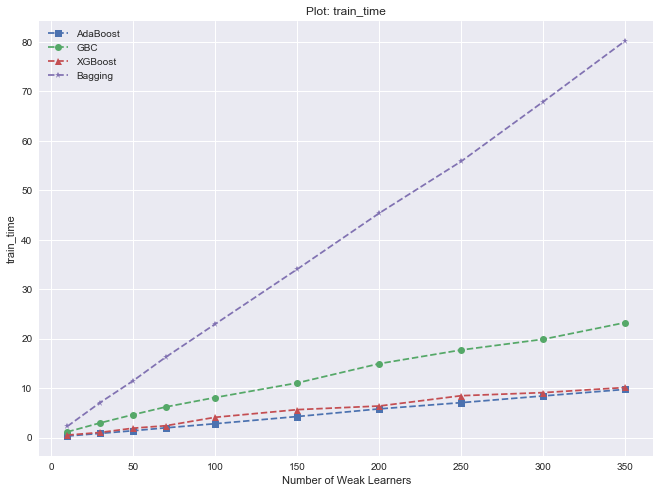

In [145]:
for col in cols:

    print("Plotting {}".format(col))
    
    plt.figure(figsize=(11, 8))
    
    plt.plot(ada_tree[col], '--s',label='AdaBoost')
    plt.plot(gbc_tree[col],'--o',label='GBC')
    plt.plot(xgb_tree[col], '--^', label='XGBoost')
    plt.plot(bag_tree[col], '--*', label='Bagging')
    
    plt.legend()
    plt.xlabel('Number of Weak Learners')
    plt.ylabel('{}'.format(col))
    plt.title('Plot: {}'.format(col))
    plt.show()

## XGBoost with grid search
* See if we can improve on the performance of the XGBoost classifier we found above
* Warning: this took about 40 minutes to complete on my 2014 Macbook Pro

In [154]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05, 0.1],
              'max_depth': [3, 4, 6, 8, 10],
              'n_estimators': [100, 200, 300, 500, 1000]}

scorer = make_scorer(fbeta_score, beta=0.5)

clf = GridSearchCV(XGBClassifier(), 
                   parameters, 
                   n_jobs=5, 
                   cv=3, 
                   scoring=scorer,
                   verbose=2, 
                   refit=True)

clf.fit(X_train, y_train)
# test model on testing set

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4 ....
[CV] learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4 ....
[CV] learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4 ....
[CV] learning_rate=0.05, max_depth=3, n_estimators=200, nthread=4 ....
[CV] learning_rate=0.05, max_depth=3, n_estimators=200, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4, total=   6.3s
[CV] learning_rate=0.05, max_depth=3, n_estimators=200, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4, total=   6.4s
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, nthread=4, total=   6.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=300, nthread=4 ....
[CV] learning_rate=0.05, max_depth=3, n_estimators=300, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=3, n_estimators=200, nthread=4, total=  13.4s
[CV] learning_rate=0.05, max_depth=3, n_es

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  4.2min


[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, nthread=4, total= 1.8min
[CV] learning_rate=0.05, max_depth=6, n_estimators=300, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, nthread=4, total= 1.9min
[CV]  learning_rate=0.05, max_depth=6, n_estimators=200, nthread=4, total=  36.5s
[CV] learning_rate=0.05, max_depth=6, n_estimators=300, nthread=4 ....
[CV] learning_rate=0.05, max_depth=6, n_estimators=300, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=6, n_estimators=200, nthread=4, total=  35.8s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=4, n_estimators=1000, nthread=4, total= 1.9min
[CV] learning_rate=0.05, max_depth=6, n_estimators=500, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=6, n_estimators=300, nthread=4, total=  54.1s
[CV] learning_rate=0.05, max_depth=6, n_estimators=500, nthread=4 ....
[CV]  learning_rate=0.05, max_depth=6, n_estimators=300, nthread=4, total=  54.

[Parallel(n_jobs=5)]: Done 150 out of 150 | elapsed: 40.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'nthread': [4], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4, 6, 8, 10], 'n_estimators': [100, 200, 300, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [156]:
predictions_test = clf.predict(X_test)
fbeta_score(y_test, predictions_test, beta=0.5)

0.75472683589261458

F-score improved by 0.67%!